In [2]:
import praw
import pandas as pd
import numpy as np

import unicodedata
import string
import re
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [4]:
reddit = praw.Reddit(client_id='5B5OQI5BAIUa1w', client_secret='5eShI_61NRHwaw1lKNzIeMUG_lwQ0Q', user_agent='Reddit WebScrapping')

In [3]:
# get 10 hot posts from the MachineLearning subreddit
hot_posts = reddit.subreddit('MachineLearning').hot(limit=10)
for post in hot_posts:
    print(post.title)

[D] Simple Questions Thread November 22, 2020
[D] Machine Learning - WAYR (What Are You Reading) - Week 100
[P] lightly - A python library for self-supervised learning
[Project] Explained implementation of the Performer
[D] AAAI reviews are ridden with Microsoft CMT technical problems!
[Project] OfficeHours: Chat with machine learning experts about anything!
[D] I have been doing a project on fruit detection using yolov4. But my model is too biased to one or more category. Later I was insisted to using equal number of images. But category A has 500 images with 10-20 bounding boxes in the image and B has 500 with 2-3 bounding box.
[Project] Software 2.0 needs Data 2.0 - and we've built the framework to make it happen
[D] DeepMind's AlphaFold 2 Explained! AI Breakthrough in Protein Folding! What we know (& what we don't - Full Video)
[N] Top AI Experts created CodeCarbon, an open-source tool to help organizations estimate and reduce the carbon footprint of computing.


In [145]:
hot_posts = reddit.subreddit('all').top(limit=10)
for post in hot_posts:
    print(post.title)

Guardians of the Front Page
Thanks, Obama.
I am Barack Obama, President of the United States -- AMA
Take your time, you got this
Blizzard Employees Staged a Walkout After the Company Banned a Gamer for Pro-Hong Kong Views
This is Shelia Fredrick, a flight attendant. She noticed a terrified girl accompanied by an older man. She left a note in the bathroom on which the victim wrote that she needed help. The police was alerted & the girl was saved from a human trafficker. We should honor our heroes.
DEMOCRACY NOW
I got a cease and desist for making the Crocs Gloves
Printers
I drew all the boys together and i did it for the internet


In [74]:
import pprint

# assume you have a Reddit instance bound to variable `reddit`
submission = reddit.submission(id="k56q01")
print(submission.title) # to make it non-lazy
pprint.pprint(vars(submission))

In the media, women politicians are often stereotyped as consensus building and willing to work across party lines. However, a new study found that women in the US tend to be more hostile than men towards their political rivals and have stronger partisan identities.
{'_comments': <praw.models.comment_forest.CommentForest object at 0x7f227c2e73d0>,
 '_comments_by_id': {'t1_gectd4x': Comment(id='gectd4x'),
                     't1_gecuecb': Comment(id='gecuecb'),
                     't1_gecwgib': Comment(id='gecwgib'),
                     't1_gecwjnp': Comment(id='gecwjnp'),
                     't1_gecwrdb': Comment(id='gecwrdb'),
                     't1_gecys6d': Comment(id='gecys6d'),
                     't1_gecz8id': Comment(id='gecz8id'),
                     't1_geczg74': Comment(id='geczg74'),
                     't1_geczsy7': Comment(id='geczsy7'),
                     't1_geczw7j': Comment(id='geczw7j'),
                     't1_geczz7s': Comment(id='geczz7s'),
            

In [13]:
posts = []
all_hot = reddit.subreddit('AskReddit')
for post in all_hot.hot(limit=3000):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.subreddit_name_prefixed, post.upvote_ratio, post.created])
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'subreddit_name_prefixed', 'upvote_ratio', 'created'])

In [14]:
posts

,title,score,id,subreddit,url,num_comments,body,subreddit_name_prefixed,upvote_ratio,created
0,Moratorium on questions related to US Politics,70760,j44ppb,AskReddit,https://www.reddit.com/r/AskReddit/comments/j4...,2,"Effective immediately until a further notice, ...",r/AskReddit,0.84,1.601708e+09
1,What did that one teacher do to you that you'l...,14526,k5g9u6,AskReddit,https://www.reddit.com/r/AskReddit/comments/k5...,5438,,r/AskReddit,0.97,1.606966e+09
2,"If when you die, someone takes the VR headset ...",70789,k59290,AskReddit,https://www.reddit.com/r/AskReddit/comments/k5...,14110,,r/AskReddit,0.86,1.606944e+09
3,When did the full weight of the gravity of thi...,1698,k5icee,AskReddit,https://www.reddit.com/r/AskReddit/comments/k5...,1317,,r/AskReddit,0.92,1.606972e+09
4,"The Lockheed SR-71 ""Blackbird"", a Mach 3+ stra...",1530,k5evem,AskReddit,https://www.reddit.com/r/AskReddit/comments/k5...,494,,r/AskReddit,0.96,1.606962e+09
...,...,...,...,...,...,...,...,...,...,...
994,What’s a thought/statement you had you believe...,3,k5lesu,AskReddit,https://www.reddit.com/r/AskReddit/comments/k5...,2,,r/AskReddit,1.00,1.606981e+09
995,Men of Reddit who didn’t have fathers growing ...,7,k5ftuf,AskReddit,https://www.reddit.com/r/AskReddit/comments/k5...,6,,r/AskReddit,0.89,1.606965e+09
996,(Predictions) When do you think 'Rick Astley -...,7,k5ftqp,AskReddit,https://www.reddit.com/r/AskReddit/comments/k5...,12,,r/AskReddit,0.82,1.606965e+09
997,If you could only listen to one song for the r...,4,k5jmbn,AskReddit,https://www.reddit.com/r/AskReddit/comments/k5...,8,,r/AskReddit,1.00,1.606976e+09


In [15]:
posts.to_csv('data/askreddit999.csv', sep='!', index=False)

In [11]:
tester = pd.read_csv('data/all3000.csv', sep='!')

In [12]:
tester

,title,score,id,subreddit,url,num_comments,body,subreddit_name_prefixed,upvote_ratio,created
0,"Hugh Keays-Byrne, of Mad Max fame, dead at 73",13735,k5fkoh,movies,https://boingboing.net/2020/12/02/hugh-keays-b...,507,NaN,r/movies,0.96,1.606964e+09
1,A kitten will always be kitten for a mother.,18383,k5f7ji,aww,https://v.redd.it/uzvz2r2lit261,193,NaN,r/aww,0.98,1.606963e+09
2,TIL Curry was introduced to Japan by the Briti...,41743,k5cmo1,todayilearned,http://www.wikipedia.org/wiki/curry,1501,NaN,r/todayilearned,0.95,1.606956e+09
3,[Charania] Los Angeles Lakers star LeBron Jame...,11417,k5e528,nba,https://twitter.com/shamscharania/status/13341...,1448,NaN,r/nba,0.94,1.606960e+09
4,Man checks Mayor where the city tax money is b...,54741,k5cc3g,PublicFreakout,https://v.redd.it/xm3u9kpcus261,2612,NaN,r/PublicFreakout,0.92,1.606955e+09
...,...,...,...,...,...,...,...,...,...,...
2995,I just got to Hutton orbital,601,k5ale4,EliteDangerous,https://www.reddit.com/r/EliteDangerous/commen...,133,I hate every single one of you.,r/EliteDangerous,0.98,1.606949e+09
2996,It's the end of times as foretold by the prophecy,1791,k58ll9,Markiplier,https://imgur.com/44TQSnZ.jpg,14,NaN,r/Markiplier,0.99,1.606942e+09
2997,Would you rather go to space or solve world hu...,666,k57jnt,polls,https://www.reddit.com/r/polls/comments/k57jnt...,121,\n\n[View Poll](https://www.reddit.com/poll/k5...,r/polls,0.97,1.606937e+09
2998,Malik Beasley This Off-Season,314,k5b58i,timberwolves,https://i.redd.it/lza38rw2ks261.jpg,50,NaN,r/timberwolves,0.99,1.606951e+09


In [157]:
posts['upvote_ratio'].describe()

count    9052.000000
mean        0.972246
std         0.032013
min         0.630000
25%         0.970000
50%         0.980000
75%         0.990000
max         1.000000
Name: upvote_ratio, dtype: float64

In [158]:
posts['subreddit_name_prefixed'].describe()

count        9052
unique       3203
top       r/memes
freq          482
Name: subreddit_name_prefixed, dtype: object

In [82]:
docs = posts['title'].tolist()

In [83]:
for i,doc in enumerate(docs):
    docs[i] = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')

In [84]:
docs

["'Bye-Bye, Betsy DeVos. You Won't Be Missed,' Says Sanders as Billionaire Education Secretary Attacks Push for Tuition-Free College",
 'socialist free college with no debt VS capitalist college in debt',
 'LPT: Put a mirror behind you at the counter or at your desk. This way angry customers who approach you will have to see themselves in the mirror behind you and the chances of them behaving irrationally lowers significantly. No one wants to see themselves act like a dickhead.',
 'Happiness in Western Australia, home of the Quokka',
 'Dont tell me tell them',
 'Bar Owner Not Complying with COVID-19 Restrictions Arrested',
 ' Majestic black jaguar',
 "[OC] just because you guys love them, here's a timelapse of me making goat, the mimic mug",
 "Layers and layers of 'facepalm'... 74 thousand billion people...",
 'Fast enough for Me!',
 'Free sandwiches',
 'Left the door open by accident and came back to this..',
 'In the media, women politicians are often stereotyped as consensus buildin

In [85]:
for i,doc in enumerate(docs):
    docs[i] = doc.lower()  

In [86]:
docs

["'bye-bye, betsy devos. you won't be missed,' says sanders as billionaire education secretary attacks push for tuition-free college",
 'socialist free college with no debt vs capitalist college in debt',
 'lpt: put a mirror behind you at the counter or at your desk. this way angry customers who approach you will have to see themselves in the mirror behind you and the chances of them behaving irrationally lowers significantly. no one wants to see themselves act like a dickhead.',
 'happiness in western australia, home of the quokka',
 'dont tell me tell them',
 'bar owner not complying with covid-19 restrictions arrested',
 ' majestic black jaguar',
 "[oc] just because you guys love them, here's a timelapse of me making goat, the mimic mug",
 "layers and layers of 'facepalm'... 74 thousand billion people...",
 'fast enough for me!',
 'free sandwiches',
 'left the door open by accident and came back to this..',
 'in the media, women politicians are often stereotyped as consensus buildin

In [87]:
for i,doc in enumerate(docs):
    docs[i] = word_tokenize(doc) # method in nltk

In [88]:
docs

[["'bye-bye",
  ',',
  'betsy',
  'devos',
  '.',
  'you',
  'wo',
  "n't",
  'be',
  'missed',
  ',',
  "'",
  'says',
  'sanders',
  'as',
  'billionaire',
  'education',
  'secretary',
  'attacks',
  'push',
  'for',
  'tuition-free',
  'college'],
 ['socialist',
  'free',
  'college',
  'with',
  'no',
  'debt',
  'vs',
  'capitalist',
  'college',
  'in',
  'debt'],
 ['lpt',
  ':',
  'put',
  'a',
  'mirror',
  'behind',
  'you',
  'at',
  'the',
  'counter',
  'or',
  'at',
  'your',
  'desk',
  '.',
  'this',
  'way',
  'angry',
  'customers',
  'who',
  'approach',
  'you',
  'will',
  'have',
  'to',
  'see',
  'themselves',
  'in',
  'the',
  'mirror',
  'behind',
  'you',
  'and',
  'the',
  'chances',
  'of',
  'them',
  'behaving',
  'irrationally',
  'lowers',
  'significantly',
  '.',
  'no',
  'one',
  'wants',
  'to',
  'see',
  'themselves',
  'act',
  'like',
  'a',
  'dickhead',
  '.'],
 ['happiness',
  'in',
  'western',
  'australia',
  ',',
  'home',
  'of',
  't

In [89]:
pt = string.punctuation
pt += '...' + '``' + "''"
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~...``\'\''

In [90]:
for i,doc in enumerate(docs):
    docs[i] = [word for word in doc if not word in pt]

In [91]:
docs

[["'bye-bye",
  'betsy',
  'devos',
  'you',
  'wo',
  "n't",
  'be',
  'missed',
  'says',
  'sanders',
  'as',
  'billionaire',
  'education',
  'secretary',
  'attacks',
  'push',
  'for',
  'tuition-free',
  'college'],
 ['socialist',
  'free',
  'college',
  'with',
  'no',
  'debt',
  'vs',
  'capitalist',
  'college',
  'in',
  'debt'],
 ['lpt',
  'put',
  'a',
  'mirror',
  'behind',
  'you',
  'at',
  'the',
  'counter',
  'or',
  'at',
  'your',
  'desk',
  'this',
  'way',
  'angry',
  'customers',
  'who',
  'approach',
  'you',
  'will',
  'have',
  'to',
  'see',
  'themselves',
  'in',
  'the',
  'mirror',
  'behind',
  'you',
  'and',
  'the',
  'chances',
  'of',
  'them',
  'behaving',
  'irrationally',
  'lowers',
  'significantly',
  'no',
  'one',
  'wants',
  'to',
  'see',
  'themselves',
  'act',
  'like',
  'a',
  'dickhead'],
 ['happiness', 'in', 'western', 'australia', 'home', 'of', 'the', 'quokka'],
 ['dont', 'tell', 'me', 'tell', 'them'],
 ['bar',
  'owner'

In [92]:
sw = stopwords.words('english')

In [93]:
more_sw = ["n't", "'s"]
sw += more_sw
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [94]:
for i,doc in enumerate(docs):
    docs[i] = [token for token in doc if token not in sw]

In [95]:
docs

[["'bye-bye",
  'betsy',
  'devos',
  'wo',
  'missed',
  'says',
  'sanders',
  'billionaire',
  'education',
  'secretary',
  'attacks',
  'push',
  'tuition-free',
  'college'],
 ['socialist',
  'free',
  'college',
  'debt',
  'vs',
  'capitalist',
  'college',
  'debt'],
 ['lpt',
  'put',
  'mirror',
  'behind',
  'counter',
  'desk',
  'way',
  'angry',
  'customers',
  'approach',
  'see',
  'mirror',
  'behind',
  'chances',
  'behaving',
  'irrationally',
  'lowers',
  'significantly',
  'one',
  'wants',
  'see',
  'act',
  'like',
  'dickhead'],
 ['happiness', 'western', 'australia', 'home', 'quokka'],
 ['dont', 'tell', 'tell'],
 ['bar', 'owner', 'complying', 'covid-19', 'restrictions', 'arrested'],
 ['majestic', 'black', 'jaguar'],
 ['oc', 'guys', 'love', 'timelapse', 'making', 'goat', 'mimic', 'mug'],
 ['layers', 'layers', "'facepalm", '74', 'thousand', 'billion', 'people'],
 ['fast', 'enough'],
 ['free', 'sandwiches'],
 ['left', 'door', 'open', 'accident', 'came', 'back']

In [96]:
lemmatizer = WordNetLemmatizer()

In [97]:
for i,doc in enumerate(docs):
    docs[i] = [lemmatizer.lemmatize(token) for token in doc]

In [98]:
docs

[["'bye-bye",
  'betsy',
  'devos',
  'wo',
  'missed',
  'say',
  'sander',
  'billionaire',
  'education',
  'secretary',
  'attack',
  'push',
  'tuition-free',
  'college'],
 ['socialist',
  'free',
  'college',
  'debt',
  'v',
  'capitalist',
  'college',
  'debt'],
 ['lpt',
  'put',
  'mirror',
  'behind',
  'counter',
  'desk',
  'way',
  'angry',
  'customer',
  'approach',
  'see',
  'mirror',
  'behind',
  'chance',
  'behaving',
  'irrationally',
  'lower',
  'significantly',
  'one',
  'want',
  'see',
  'act',
  'like',
  'dickhead'],
 ['happiness', 'western', 'australia', 'home', 'quokka'],
 ['dont', 'tell', 'tell'],
 ['bar', 'owner', 'complying', 'covid-19', 'restriction', 'arrested'],
 ['majestic', 'black', 'jaguar'],
 ['oc', 'guy', 'love', 'timelapse', 'making', 'goat', 'mimic', 'mug'],
 ['layer', 'layer', "'facepalm", '74', 'thousand', 'billion', 'people'],
 ['fast', 'enough'],
 ['free', 'sandwich'],
 ['left', 'door', 'open', 'accident', 'came', 'back'],
 ['medium',


In [99]:
# creating the vocabulary and initializing the BoW matrix
vocabulary = set()
for doc in docs:
    for token in doc:
        vocabulary.add(token)

vocabulary_lookup = {word: i for i, word in enumerate(vocabulary)}
matrix = np.zeros((len(docs), len(vocabulary)))

In [100]:
vocabulary_lookup

{'item': 0,
 'beef': 1,
 'selfish': 2,
 'taught': 3,
 'attending': 4,
 '9.1': 5,
 'honored': 6,
 'seat': 7,
 'zapojeta': 8,
 'recently': 9,
 'verry': 10,
 'activist': 11,
 'honor': 12,
 'harem': 13,
 'advocacy': 14,
 '30,000-year': 15,
 'certainly': 16,
 'update': 17,
 'change': 18,
 'bbc': 19,
 'vorstellung': 20,
 'go~': 21,
 'room': 22,
 'bikini': 23,
 'deandre': 24,
 'launched': 25,
 'ceo': 26,
 'fact': 27,
 'animation': 28,
 'timestamp': 29,
 '41': 30,
 'bacon': 31,
 'used': 32,
 'uprising': 33,
 'rising': 34,
 'announces': 35,
 '0.005': 36,
 'rebel': 37,
 '1983': 38,
 'explained': 39,
 'strictly': 40,
 'smile': 41,
 'dino': 42,
 'fallen': 43,
 'weebs': 44,
 'georgia': 45,
 'actor': 46,
 '100': 47,
 'virus': 48,
 'tracker': 49,
 'saver': 50,
 'nar': 51,
 'reichstag': 52,
 'noel': 53,
 'chicago': 54,
 'scheme': 55,
 'render': 56,
 'level': 57,
 'modeled': 58,
 'however': 59,
 'dva': 60,
 'stage': 61,
 'pfizer/biontech': 62,
 'also': 63,
 'mean': 64,
 '//': 65,
 'birthplace': 66,
 'w

In [101]:
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [102]:
for doc_id, doc in enumerate(docs):
    for token in doc:
        word_id = vocabulary_lookup[token]
        matrix[doc_id][word_id] += 1

In [103]:
columns = sorted(vocabulary_lookup, key=lambda key: vocabulary_lookup[key])
df = pd.DataFrame(matrix.astype('int'), columns=columns)

In [104]:
df

,item,beef,selfish,taught,attending,9.1,honored,seat,zapojeta,recently,...,galaxy,frag,30,required,elon,delivered,sarah,distanced,po,shadow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
tf = df / df.sum(axis=1).values.reshape(-1, 1); tf.round(2)

,item,beef,selfish,taught,attending,9.1,honored,seat,zapojeta,recently,...,galaxy,frag,30,required,elon,delivered,sarah,distanced,po,shadow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# computing the inverse document frequency
idf = np.log(matrix.shape[0] / np.sum(matrix > 0, axis=0)); idf.round(2)

array([8.01, 8.01, 8.01, ..., 8.01, 8.01, 6.91])

In [107]:
# term frequency, inverse document frequency matrix
tfidf = tf * idf; tfidf.round(2)

,item,beef,selfish,taught,attending,9.1,honored,seat,zapojeta,recently,...,galaxy,frag,30,required,elon,delivered,sarah,distanced,po,shadow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
normalized = tfidf / np.linalg.norm(tfidf, axis=1, ord=2).reshape(-1, 1)
normalized

,item,beef,selfish,taught,attending,9.1,honored,seat,zapojeta,recently,...,galaxy,frag,30,required,elon,delivered,sarah,distanced,po,shadow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
for i in range(4):
    for j in range(i+1,4):
        print('Euclidean Distance between post {} and {} is {}'.format(i,j, 
                np.linalg.norm(normalized.iloc[i].values - normalized.iloc[j].values)) )

Euclidean Distance between post 0 and 1 is 1.3326741572134828
Euclidean Distance between post 0 and 2 is 1.4142135623730951
Euclidean Distance between post 0 and 3 is 1.4142135623730951
Euclidean Distance between post 1 and 2 is 1.414213562373095
Euclidean Distance between post 1 and 3 is 1.414213562373095
Euclidean Distance between post 2 and 3 is 1.414213562373095


In [110]:
ed = []
edi = []
for i in range(99):
    for j in range(i+1,99):
        x = np.linalg.norm(normalized.iloc[i].values - normalized.iloc[j].values)
        
        edi.append('Euclidean Distance between report {} and {} is {}'.format(i,j,x))
        
        ed.append(x)

In [111]:
ed

[1.3326741572134828,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.414213562373095,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.4142135623730951,
 1.41421356237

In [112]:
edi

['Euclidean Distance between report 0 and 1 is 1.3326741572134828',
 'Euclidean Distance between report 0 and 2 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 3 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 4 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 5 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 6 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 7 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 8 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 9 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 10 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 11 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 12 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 13 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 14 is 1.4142135623730951',
 'Euclidean Distance between report 0 and 1

In [113]:
cs = []
csi = []

for i in range(99):
    for j in range(i+1,99):
        x = np.dot(normalized.iloc[i].values, normalized.iloc[j].values)
        csi.append('Cosine Similarity between report {} and {} is {}'.format(i,j,x))
        cs.append(x)

In [114]:
cs

[0.1119897953476667,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.11287193485271976,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.049965612690769046,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.12010807215371049,
 0.0,
 0.0,
 0.0,


In [115]:
csi

['Cosine Similarity between report 0 and 1 is 0.1119897953476667',
 'Cosine Similarity between report 0 and 2 is 0.0',
 'Cosine Similarity between report 0 and 3 is 0.0',
 'Cosine Similarity between report 0 and 4 is 0.0',
 'Cosine Similarity between report 0 and 5 is 0.0',
 'Cosine Similarity between report 0 and 6 is 0.0',
 'Cosine Similarity between report 0 and 7 is 0.0',
 'Cosine Similarity between report 0 and 8 is 0.0',
 'Cosine Similarity between report 0 and 9 is 0.0',
 'Cosine Similarity between report 0 and 10 is 0.0',
 'Cosine Similarity between report 0 and 11 is 0.0',
 'Cosine Similarity between report 0 and 12 is 0.0',
 'Cosine Similarity between report 0 and 13 is 0.0',
 'Cosine Similarity between report 0 and 14 is 0.0',
 'Cosine Similarity between report 0 and 15 is 0.0',
 'Cosine Similarity between report 0 and 16 is 0.0',
 'Cosine Similarity between report 0 and 17 is 0.0',
 'Cosine Similarity between report 0 and 18 is 0.0',
 'Cosine Similarity between report 0 and

In [116]:
import seaborn as sns

In [175]:
total = df.sum()
total.sort_values(ascending=False, inplace=True)

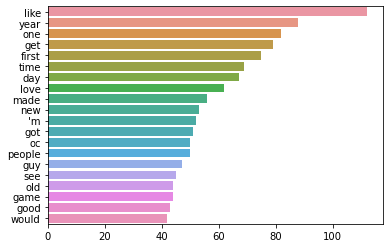

In [176]:
x, y= [], []
for i in range(20):
        x.append(total.index[i])
        y.append(total[i])
sns.barplot(x=y,y=x)

In [171]:
y1 = posts['score'].tolist()

In [172]:
y1

[13431,
 21090,
 36807,
 19523,
 17006,
 13567,
 52215,
 12760,
 11370,
 31160,
 24890,
 11085,
 36004,
 5459,
 28203,
 20050,
 17331,
 38076,
 6871,
 11162,
 9775,
 9316,
 47146,
 18329,
 57864,
 7447,
 21097,
 5533,
 21010,
 18314,
 7381,
 34588,
 5424,
 14533,
 10207,
 11015,
 7072,
 57437,
 15840,
 6223,
 22714,
 10836,
 43539,
 7392,
 5252,
 12923,
 10913,
 96465,
 12031,
 34508,
 3352,
 33262,
 4877,
 3450,
 5158,
 6794,
 2823,
 4975,
 8333,
 7873,
 42989,
 20211,
 12889,
 12591,
 15441,
 3676,
 2637,
 2678,
 9605,
 3721,
 18172,
 14091,
 2803,
 32848,
 9920,
 12633,
 7787,
 4605,
 11032,
 7537,
 30493,
 33575,
 6561,
 17460,
 3357,
 46602,
 3921,
 2429,
 8082,
 9677,
 39074,
 1969,
 3074,
 2705,
 41310,
 26326,
 30695,
 5710,
 2273,
 3901,
 11820,
 3160,
 5040,
 12357,
 7402,
 20683,
 14953,
 35001,
 27051,
 10496,
 8082,
 2129,
 7898,
 5704,
 14764,
 10139,
 5009,
 11580,
 13020,
 3992,
 1771,
 2031,
 2638,
 2237,
 9503,
 14296,
 4110,
 31723,
 2480,
 2282,
 9773,
 3153,
 7334,

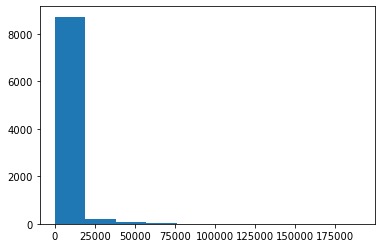

In [173]:
plt.hist(y1)
plt.show()

In [174]:
posts['score'].describe()

count      9052.000000
mean       2911.339814
std        8303.800794
min          59.000000
25%         195.000000
50%         499.000000
75%        1712.000000
max      189937.000000
Name: score, dtype: float64

In [185]:
corpus = posts['title'].tolist()

In [186]:
vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english')

In [187]:
X = vectorizer.fit_transform(corpus)

In [167]:
vectorizer.get_feature_names()

['000',
 '004',
 '005',
 '01',
 '05',
 '06',
 '10',
 '100',
 '1000',
 '10600k',
 '10700k',
 '10801350',
 '1080p',
 '10k',
 '10yo',
 '11',
 '11m',
 '11th',
 '12',
 '1200',
 '1200x872',
 '120mm',
 '1242x2688',
 '126lb',
 '127',
 '1280x1015',
 '12tb',
 '13',
 '1367x2048',
 '14',
 '1439',
 '1479',
 '15',
 '150',
 '152s',
 '154',
 '1560',
 '15h30',
 '16',
 '17',
 '172lbs',
 '175',
 '18',
 '18f',
 '18yo',
 '19',
 '1903',
 '1910s',
 '191lb',
 '1920',
 '1929',
 '1933',
 '1940s',
 '1942',
 '1943',
 '1945',
 '1946',
 '1949',
 '1956',
 '1958',
 '1966',
 '1970',
 '1970s',
 '1975',
 '1983',
 '1989',
 '1990s',
 '1995',
 '1996',
 '19f',
 '1am',
 '1m',
 '1st',
 '1v1',
 '20',
 '200',
 '2000x3000',
 '2001',
 '2003',
 '2005',
 '2006',
 '2008',
 '2010',
 '2011',
 '2012',
 '201202',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2030',
 '2077',
 '2080ti',
 '21',
 '21st',
 '22',
 '225',
 '22b',
 '23',
 '230',
 '23000',
 '2336',
 '23f',
 '24',
 '25',
 '250',
 '250387',
 '2560x1080',
 '25th'

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y1)

In [190]:
#clf = MultinomialNB()
#clf.fit(X_train, y_train)

MultinomialNB()

In [191]:
#y_predict = clf.predict(X_test)

In [192]:
#clf.score(X_test, y_test)

0.004418912947414936

In [193]:
#gnb = GaussianNB()

In [194]:
#y_pred = gnb.fit(X_train.toarray(), y_train).predict(X_test.toarray())

In [195]:
#print("Number of mislabeled points out of a total %d points : %d"
#...       % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 2263 points : 2252


In [196]:
#confusion_matrix(y_true = y_test, y_pred = y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
#gnb.score(X_test.toarray(), y_test)

In [198]:
#rf_clf = RandomForestClassifier()

In [ ]:
#rf_clf.fit(X_train, y_train)

In [ ]:
#y_pred = rf_clf.predict(X_test)

In [ ]:
#rf_clf.score(X_test, y_test)